In [0]:
# !pip install ipython-autotime
# %load_ext autotime

In [1]:
#command to mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
 #command to load dataset from drive
 !unzip -q "/content/drive/My Drive/20_newsgroups.zip"
#!unzip -q "/content/20_newsgroups.zip"

In [3]:
pip install num2words

     |████████████████████████████████| 102kB 2.5MB/s 


In [0]:
from collections import defaultdict
from collections import Counter
from num2words import num2words

import re
import os
import math
import nltk
import numpy as np
import heapq
import matplotlib.pyplot as plt


**pre-process data**

In [0]:
import re

def pre_process(filet):
  f = open(filet,'r',encoding="ISO-8859-1")
  data = f.readlines()
  docs = []

  for sent in data:
    sent = re.sub(r'[\.•,;:?!#=+$%^&*_~><\-\(\)\{\}\[\]\"\'\|\/]','',sent)
    sent = re.sub('\n',' ',sent)
    docs.append(sent.lower())
  return docs

**number to words**

In [0]:
def numberTowords(wordt):
  if(wordt.isnumeric()):
    return num2words(wordt)
  else:
    return wordt

**remove stop-words**

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def removeStop(tokenst):
  stop = set(stopwords.words('english'))
  f_tokens = []
  
  for w in tokenst:
    if w not in stop:
      f_tokens.append(w)
  
  return f_tokens

**generate tokens**

In [9]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lm = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def tokenise(docst):
  i = 0
  lem_words = []

  for k in docst:
    tokens = k.split()
    f_tokens = removeStop(tokens)
    
    for j in f_tokens:
      lem_words.append(lm.lemmatize(j))
    
  return lem_words

**remove-metadata**

In [0]:
import re
def meta_data(path,f):
    output = []
    with open(os.path.join(path,f),"r+",encoding="ISO-8859-1") as fh:
        for line in fh:
            if not re.search("[\w]+:\s",line):
                output.append(line)
        fh.close()

        fh = open(os.path.join(path,f),"w")
        fh.writelines(output)
        fh.close()
        newoutput=[]
        fh=open(os.path.join(path,f),"r+",encoding="ISO-8859-1")
        for line in fh:
            if not re.search("(--)+|(==)+",line):
                newoutput.append(line)
            else:
                break

        fh.close()

        fh = open(os.path.join(path,f),"w")
        fh.seek(0)
        fh.truncate()
        fh.writelines(newoutput)
        fh.close()


**Mapping documents**

In [0]:
directory = ["rec.sport.hockey","sci.med","comp.graphics","sci.space","talk.politics.misc"]
path = "/content/20_newsgroups/"


In [13]:
mapping = defaultdict(str)

count=0

for d in directory:
  flist = []
  d_path = path+d                   # path that will lead us inside the directory
  flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
  for i in flist:
    count = count+1
    mapping[d+'/'+i] = str(count) + "_" + d

print(len(mapping))

5000


**Splitting into train and test data**

In [0]:
# We are going to split the data class-wise, i.e., some random documents as training set
# and some other random sample as testing set
# Reference :: https://stackoverflow.com/questions/17412439/how-to-split-data-into-trainset-and-testset-randomly

import random

train_data = []
test_data = []

def split_train_test(ratio):
  for d in directory:
    flist = []
    d_path = path+d                                       # path that will lead us inside the directory
    flist = os.listdir(d_path)                            # this will list all the files in the folder 'd'

    random.shuffle(flist)                                 # shuffling the files present in the class

    train = flist[:int((len(flist)+1)*(ratio/100))]       # 80% to training set
    test = flist[int(len(flist)*(ratio/100)):]

    for i in train:
      train_data.append(d+'/'+i)

    for i in test:    
      test_data.append(d+'/'+i)
    
  random.shuffle(train_data)
  random.shuffle(test_data)

In [0]:
# Enter the split ratio of the dataset in the function as a parameter. The ratio used here is 80:20
split_train_test(80)

###TRAINING PART

**Building vocabulary**\
and\
**Dictionary of tokens**

In [0]:
def build_dictionaries(train_data):

  vocab = set()
  tokens_dict = defaultdict(list)                           #dictionary that stores tokens of each class

  wd_count = defaultdict(lambda:defaultdict(lambda:0))      # dictionary that stores count(term,class) i.e. tf
  w_count = defaultdict(lambda:0)                           # dictionary that stores df(term)

  for item in train_data:
    d = mapping[item].split('_')[1]        # fetching the directory name from the mapping dict
    
    d_path = path + d                      # path that will lead us inside the directory

    f = item.split('/')[1]                 # fetching file name from the item in train_data
    
    meta_data(d_path,f)
    pre_p = pre_process(d_path+'/'+f)
    lemmas = tokenise(pre_p)
   
    for term in lemmas:
      term = numberTowords(term)
      vocab.add(term)
      tokens_dict[d].append(term)
      wd_count[d][term] += 1
    
  for d in directory:
    for word in vocab:
      if word in tokens_dict[d]:
        w_count[word] += 1

  return vocab,tokens_dict,wd_count,w_count

In [0]:
vocab,tokens_dict,wd_count,w_count = build_dictionaries(train_data)

**calculating tf-idf scores**

In [0]:
def compute_tf():
  tf = defaultdict(lambda:defaultdict(lambda:0.0))
  idf = defaultdict(lambda:0.0)

  for i in wd_count:      # i takes values in directory
    for j in wd_count[i]:  # takes values in vocab
      temp = wd_count[i][j]
      tf[i][j] = 1 + np.log((1 + temp)*1.0)

  for j in w_count:   # j takes values in vocab
    temp = 1 + w_count[j]
    idf[j]= np.log((len(directory)*1.0/temp))
  
  return tf,idf


tf,idf = compute_tf()

In [0]:
def calc_tf_idf():
  tf_idf = defaultdict(lambda:defaultdict(lambda:0.0))

  for i in wd_count:  # i takes values in directory
    for j in wd_count[i]: # j takes values in vocab
      tf_idf[i][j] = tf[i][j] * idf[j]
  
  return tf_idf


tf_idf = calc_tf_idf()

**Selecting features based on tf-idf**

In [0]:
def reduce_feature(k):
  selected_features = defaultdict(list)

  for d in directory:
    toplist = heapq.nlargest(k, tf_idf[d].items(), key=lambda x: x[1]) # x[1] because we want to sort according to 2nd value of the tuple

    for i in toplist:
      selected_features[d].append(i[0])
  
  return selected_features

In [0]:
k = 8000
selected_features = reduce_feature(k)

**Creating tokens dictionary for the new feature space**

In [0]:
def build_vocab():
  new_vocab = set()

  for d in directory:
    for i in selected_features[d]:
      new_vocab.add(i)
  
  return new_vocab


new_vocab = build_vocab()

In [23]:
print(len(new_vocab))

33685


In [0]:
def generate_tokens():
  reduced_tokens = defaultdict(list)
    
  for d in directory:
    for word in tokens_dict[d]:
      if word in new_vocab:
        reduced_tokens[d].append(word)
  
  return reduced_tokens


reduced_tokens = generate_tokens()

###CLASSIFICATION of TEST DATA


###### NAIVE BAYES

**Calculating Probabilities**

In [0]:
#used add-one smoothing
def store_prob():
  log_prob = defaultdict(lambda:defaultdict(lambda:0.0))
  for word in new_vocab:
    for d in directory:
      l1 = Counter(reduced_tokens[d])
      count_word = l1[word] + 1
      count_token = len(reduced_tokens[d]) + len(new_vocab)
      
      p_w = np.log((count_word*1.0/count_token))      
      log_prob[word][d] = p_w
    
  return log_prob

log_prob = store_prob()

 > **1. Naive Bayes**

**Generate heat plot**

In [0]:
from sklearn.metrics import confusion_matrix

def heat_plot(y_true,y_pred,matrix):
  
  labels = ["rec.sport.hockey","sci.med","comp.graphics","sci.space","talk.politics.misc"]

  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(matrix,cmap = 'tab20c')
  fig.colorbar(cax)
  ax.set_fc('y')
  ax.set_xticklabels([''] + labels,rotation=30)
  ax.set_yticklabels([''] + labels)

  # Loop over data dimensions and create text annotations.
  for i in range(5):
    for j in range(5):
      text = ax.text(j, i, matrix[i, j],ha="center", va="center", color="w")
  
  fig.tight_layout()
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

**Classifying test data**

In [0]:
from sklearn.metrics import confusion_matrix

def find_class_NB(test_data):

  p_c = np.log((1/5))                       # because each class is equally likely
  correct = 0
  y_true=[]
  y_pred=[]

  print("Split ratio of the data set = 80:20")
  for item in test_data:
    
    output_prob = []

    d = mapping[item].split('_')[1]          # fetching the directory name from the mapping dict
    label = d
    # print("True Label =",label)

    d_path = path + d                        # path that will lead us inside the directory
    f = item.split('/')[1]                   # fetching file name from the item in train_data
    
    meta_data(d_path,f)
    pre_p = pre_process(d_path+'/'+f)
    lemmas = tokenise(pre_p)

    for d in directory:
      prob = 0
      for term in lemmas:
        term = numberTowords(term)

        if(term in new_vocab):
          prob += log_prob[term][d]
        else:
          prob += np.log(1.0/(len(reduced_tokens[d]) + len(new_vocab)))
      prob += p_c
      output_prob.append((prob,d))

    #print(output_prob)
    predicted = max(output_prob)[1]

    # print("predicted =", predicted)

    if(predicted == label):
      correct +=1
    y_true.append(label)
    y_pred.append(predicted)

  
  print("Number of features selected using TF-IDF technique = ",k)
  print("\nTotal number of documents tested =",len(test_data))
  print("Number of documents correctly predicted =",correct)

  print("Accuracy = ", correct/len(test_data)*100)
  c = confusion_matrix(y_true, y_pred, labels=directory)
  print("\nConfusion matrix::\n",c)
  # print(c)
  print()
  heat_plot(y_true,y_pred,c)

Split ratio of the data set = 80:20
Number of features selected using TF-IDF technique =  8000

Total number of documents tested = 1000
Number of documents correctly predicted = 923
Accuracy =  92.30000000000001

Confusion matrix::
 [[184   0   6   1   9]
 [  0 175   8   5  12]
 [  2   2 189   5   2]
 [  0   2   9 181   8]
 [  0   3   2   1 194]]



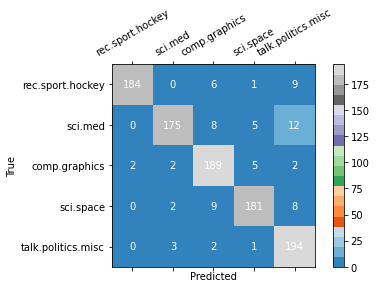

In [30]:
find_class_NB(test_data)

###### K- NN

 > **2. k-Nearest Neighbour**

**new tf-idf**

In [0]:
def build_tf(train_data):
  tf = defaultdict(lambda:defaultdict(lambda:0))
  doc_list = defaultdict(list)

  for d in directory:
    flist = []
    d_path = path+d                   # path that will lead us inside the directory
    flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
    
    for f in flist:
      i = d+'/'+f
      if i in train_data:
        doc_list[d].append(f)
        sf = selected_features[d]

        meta_data(d_path,f)
        pre_p = pre_process(d_path+'/'+f)
        lemmas = tokenise(pre_p)

        for term in lemmas:
          term = numberTowords(term)

          if term in sf:
            tf[i][term] +=1
  
  return tf,doc_list

In [0]:
tf_dict,docs = build_tf(train_data)

**Generate document vector**

In [0]:
def document_vector(file):
  tf_values = tf_dict[file]
  d_vector = np.zeros(len(new_vocab))
  
  for pos,w in enumerate(new_vocab):
    d_vector[pos] = tf_values[w]
  
  return d_vector

**Generate test vector**

In [0]:
def test_vector(file_path):
  test_tf = defaultdict(lambda:0)

  pre_p = pre_process(file_path)
  lemmas = tokenise(pre_p)

  for w in lemmas:
    w = numberTowords(w)
    test_tf[w] +=1
  
  t_vector = np.zeros(len(new_vocab))

  for pos,w in enumerate(new_vocab):
    t_vector[pos] = test_tf[w]

  return t_vector

**Compute Euclidean distance**

In [0]:
def compute_euclidean(t_vector,d_vector):
  diff = t_vector - d_vector
  diff = diff * diff

  dist = np.sqrt(np.sum(diff))

  return dist

**Classifying test data**

In [0]:
def knn(k,result):
  prediction = []

  res = heapq.nsmallest(k, result, key=lambda x: x[0])
  
  for i in res:
    predicted = i[1].split('/')[0]
    prediction.append(predicted)
    
  return prediction

In [0]:
def find_class_knn(test_data):
  
  print("Split ratio of the data set = 50:50")
  n=3
  print("\nRESULTS OF K-NN FOR k =",n,"\n")
  correct = 0
  y_true = []
  y_pred = []
  count = 0
  for item in test_data:
    d = item.split('/')[0]                   # fetching the directory name from the mapping dict
    f = item.split('/')[1]                   # fetching file name from the item in train_data

    label = d
    y_true.append(label)
    # print("\nTrue Label =",label)

    d_path = path + d                        # path that will lead us inside the directory
    
    t_vector = test_vector(d_path+'/'+f)            # generate test vector
    output_dist = []
    
    for d in directory:
      for f in docs[d]:
        d_vector = document_vector(d+'/'+f)

        dist = compute_euclidean(t_vector,d_vector)
        output_dist.append((dist,d+'/'+f))
    result = knn(n,output_dist)
    predicted = max(set(result), key = result.count)          #finds the class that occurs max times
    y_pred.append(predicted)
    # print("Predicted Label = ",predicted)

    if(predicted==label):
      correct+=1

  print("Number of features selected using tf-idf technique = ",k)
  print("\nTotal number of documents tested =",len(test_data))
  print("Number of documents correctly predicted =",correct)
  
  print("Accuracy = ", correct/len(test_data)*100)
  c = confusion_matrix(y_true, y_pred, labels=directory)
  print("\nConfusion matrix::\n",c)
  print()
  heat_plot(y_true,y_pred,c)


In [0]:
find_class_knn(test_data)